In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
data = pd.read_csv('/content/Battery_RUL.csv')
data

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


In [5]:
data.describe(include = 'all')

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


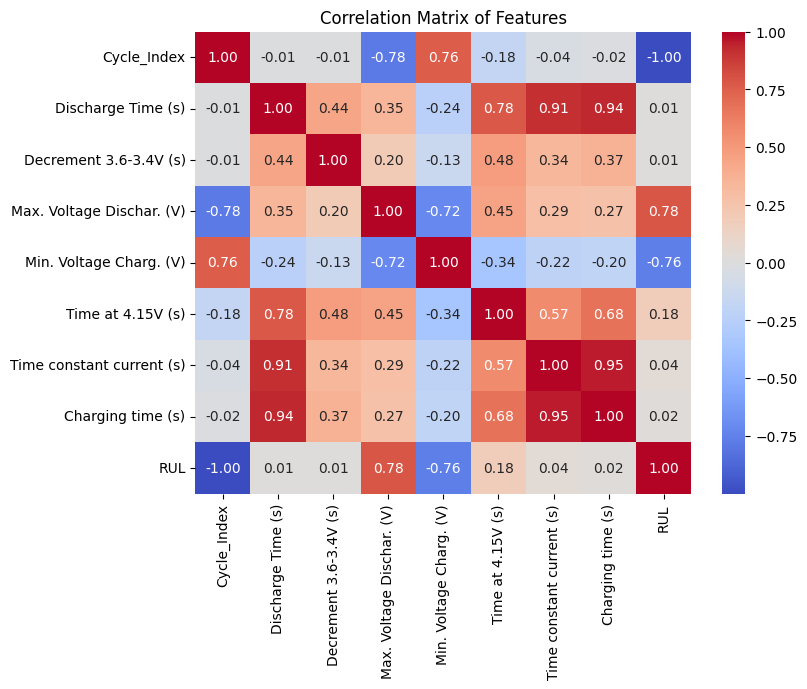

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [7]:
X=data.drop(labels=['RUL'], axis=1)
y=data['RUL']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaling_pipeline = Pipeline([
    ('minmax', MinMaxScaler()),
    ('scaler', StandardScaler())
])

data_scaled = pd.DataFrame(scaling_pipeline.fit_transform(X), columns=X.columns)
X = pd.DataFrame(scaling_pipeline.fit_transform(data_scaled), columns=data_scaled.columns)

with open('scaler.pkl', 'wb') as f:
    pickle.dump((scaling_pipeline), f)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 4,random_state=42)
X_pca = pca.fit_transform(X)

with open('PCA.pkl', 'wb') as f:
    pickle.dump((pca), f)

In [10]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [11]:
# Acertainning dependency between features and a continuous target variable,
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train,y_train)
mutual_info

array([2.23411277, 2.48687992, 2.34877264, 2.06546733])

In [12]:
mutual_info = pd.Series(mutual_info)
mutual_info.sort_values(ascending=False)

,0
1,2.486880
2,2.348773
0,2.234113
3,2.065467


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(120,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(80,activation= 'linear'),
    tf.keras.layers.Dense(50,activation= 'relu'),
    tf.keras.layers.Dense(25,activation= 'leaky_relu'),
    tf.keras.layers.Dense(1,activation='relu')
])

model.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae'])

model.fit(X_train,y_train,epochs = 100,validation_data=(X_train, y_train))

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - val_mae: 555.7553
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 554.9188 - mae: 554.9188 - val_loss: 555.7553 - va

In [14]:
# Evaluate the model on the training data
loss_train, MAE_train = model.evaluate(X_train, y_train)
print(f"Training Loss: {loss_train:.4f}")
print(f"Training MAE: {MAE_train:.4f}")

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 556.4424 - mae: 556.4424
Training Loss: 555.7553
Training MAE: 555.7553


In [15]:
loss_test, MAE_test = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test MAE: {MAE_test:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 541.7903 - mae: 541.7903
Test Loss: 547.9502
Test MAE: 547.9502


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


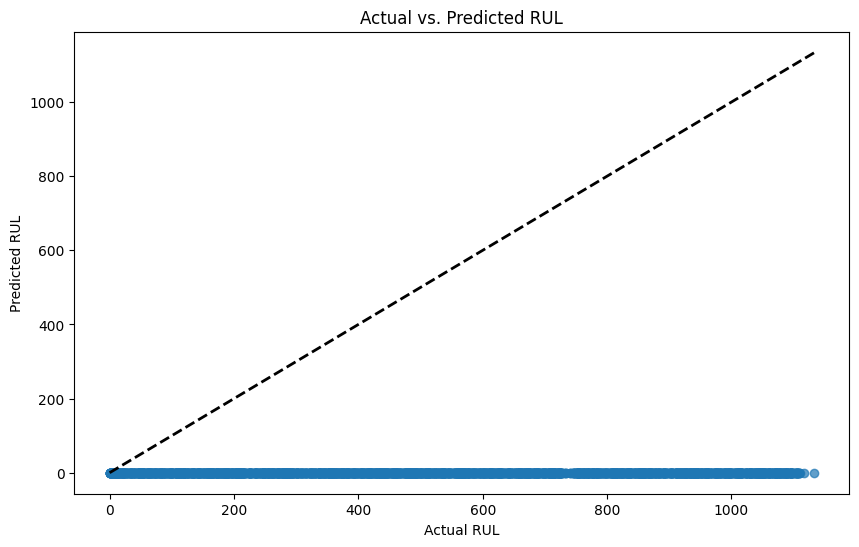

In [16]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

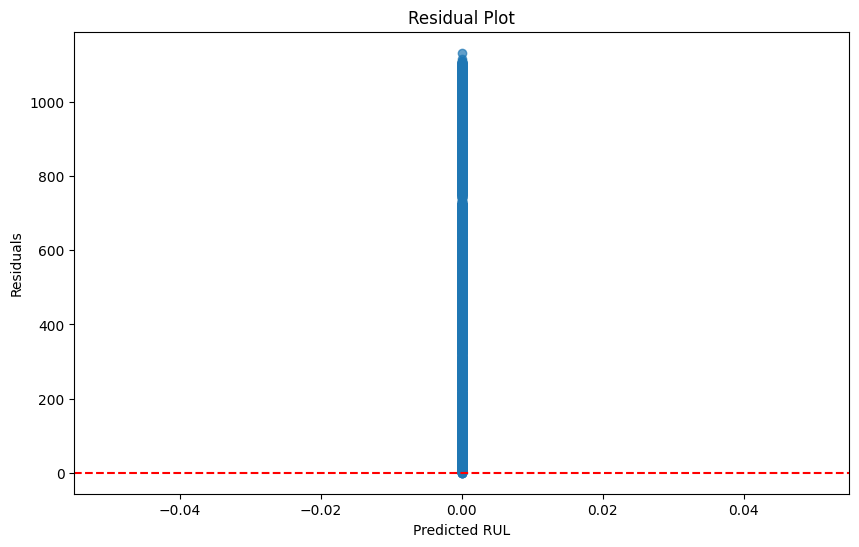

In [17]:
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [18]:
import tensorflow as tf

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(81,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(25,activation ='relu'),
    tf.keras.layers.Dense(36,activation ='linear'),
    tf.keras.layers.Dense(25,activation ='leaky_relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu'),
])

model_1.compile(loss= 'mae',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae'])

model_1.fit(X_train,y_train,epochs = 120, validation_data=(X_train,y_train))

Epoch 1/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 327.5435 - mae: 327.5435 - val_loss: 46.3992 - val_mae: 46.3992
Epoch 2/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 44.5463 - mae: 44.5463 - val_loss: 41.4900 - val_mae: 41.4900
Epoch 3/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 40.8653 - mae: 40.8653 - val_loss: 38.9293 - val_mae: 38.9293
Epoch 4/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.6395 - mae: 38.6395 - val_loss: 38.7544 - val_mae: 38.7544
Epoch 5/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.8689 - mae: 37.8689 - val_loss: 38.1821 - val_mae: 38.1821
Epoch 6/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.2776 - mae: 37.2776 - val_loss: 39.9179 - val_mae: 39.9179
Epoch 7/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.7123 - mae: 36.7123 - val_loss: 35.9150 - val_mae: 35.9150
Epoch 8/120
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.0317 - mae: 36.0317 - val_loss: 35.9594 - val_mae: 35.9594
Epoch 9/120
37

In [19]:
# Evaluate the model on the training data
loss_train, MAE_train = model_1.evaluate(X_train, y_train)
print(f"Training Loss: {loss_train:.4f}")
print(f"Training MAE: {MAE_train:.4f}")

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9210 - mae: 9.9210
Training Loss: 10.0771
Training MAE: 10.0771


In [20]:
loss_test, MAE_test = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test MAE: {MAE_test:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.1883 - mae: 10.1883
Test Loss: 10.4737
Test MAE: 10.4737


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


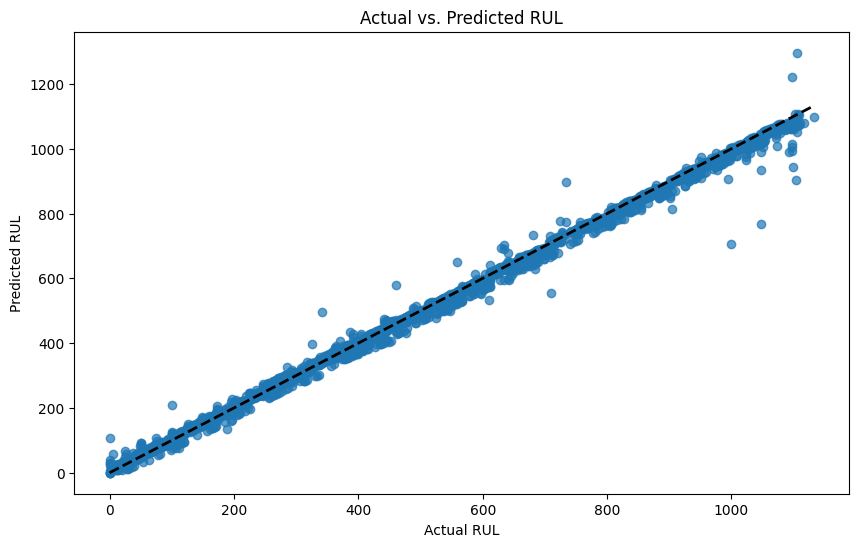

In [21]:
y_pred_1 = model_1.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_1, alpha=0.7)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

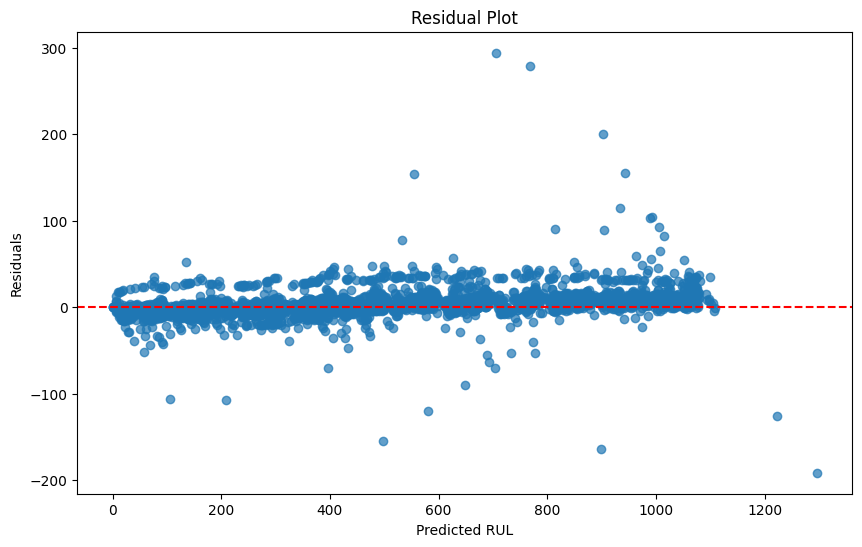

In [22]:
residuals = y_test - y_pred_1.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_1, residuals, alpha=0.7)
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [23]:
with open('Model.pkl', 'wb') as f:
    pickle.dump((model_1), f)